<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/SVM_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

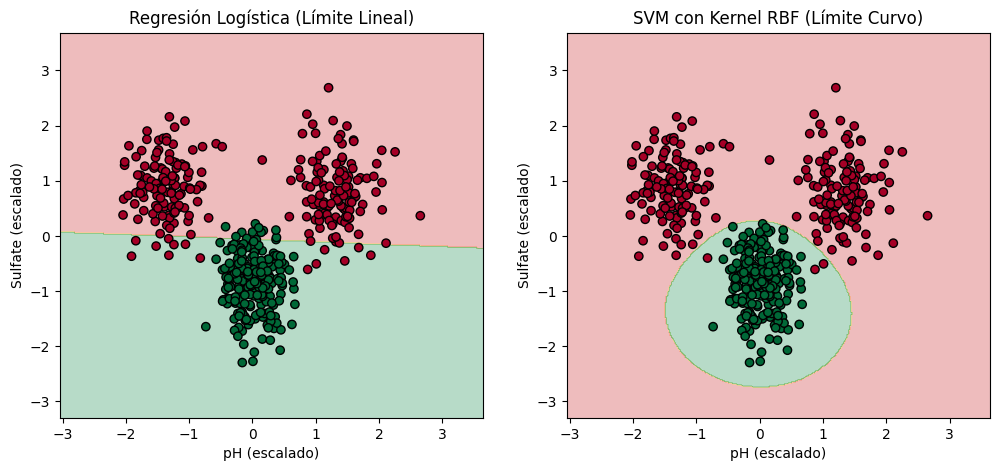

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


# 1. CREACIÓN DE DATOS ESTRUCTURADOS (Simulando Calidad de Agua)
np.random.seed(42)
n_samples = 300

# Clase 0: Agua No Potable (pH muy ácido o muy básico, altos sulfatos)
class0_ph = np.concatenate([np.random.normal(4, 0.8, 150), np.random.normal(10, 0.8, 150)])
class0_sulfate = np.random.normal(400, 50, 300)

# Clase 1: Agua Potable (pH neutro 6-8, sulfatos bajos)
class1_ph = np.random.normal(7, 0.6, 300)
class1_sulfate = np.random.normal(250, 40, 300)

# Unir todo en un DataFrame
df = pd.DataFrame({
    'ph': np.concatenate([class0_ph, class1_ph]),
    'Sulfate': np.concatenate([class0_sulfate, class1_sulfate]),
    'Potability': np.concatenate([np.zeros(300), np.ones(300)])
})

# 2. PREPARACIÓN Y ESCALADO
X = df[['ph', 'Sulfate']]
y = df['Potability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. ENTRENAMIENTO DE MODELOS
log_reg = LogisticRegression().fit(X_train_scaled, y_train)
svm_model = SVC(kernel='rbf', C=0.01).fit(X_train_scaled, y_train)

# 4. VISUALIZACIÓN DE FRONTERAS (La "magia")
def plot_boundary(model, title):
    h = .02
    x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
    y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn')
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, edgecolors='k', cmap='RdYlGn')
    plt.title(title)
    plt.xlabel('pH (escalado)')
    plt.ylabel('Sulfate (escalado)')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_boundary(log_reg, "Regresión Logística (Límite Lineal)")
plt.subplot(1, 2, 2)
plot_boundary(svm_model, "SVM con Kernel RBF (Límite Curvo)")
plt.show()

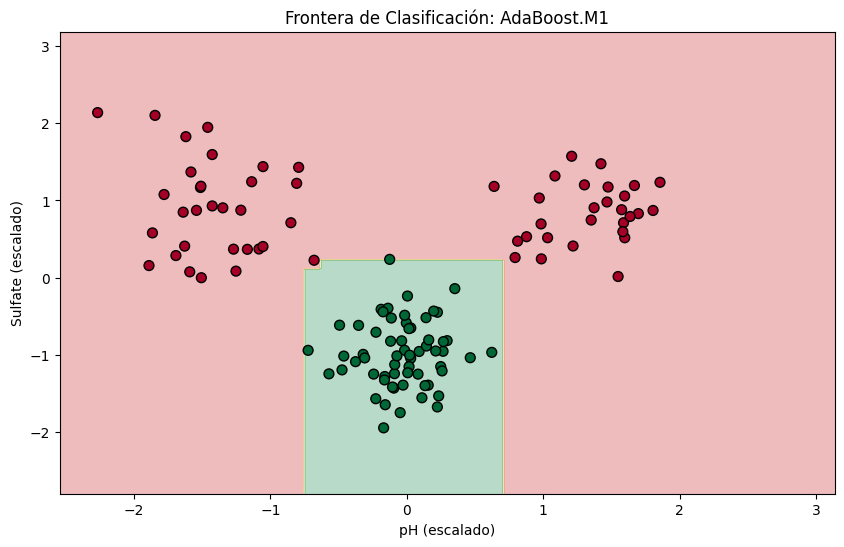

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# 1. Definir y Entrenar el modelo (Asegúrate de haber corrido la celda de los datos antes)
# Usamos n_estimators=50 como sugiere la teoría de AdaBoost.M1
ada_model = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_model.fit(X_train_scaled, y_train)

# 2. Realizar las predicciones
y_pred = ada_model.predict(X_test_scaled)

# 3. Calcular y mostrar la Matriz de Confusión
print(f"Precisión Final AdaBoost: {accuracy_score(y_test, y_pred):.2f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Potable', 'Potable'])

plt.figure(figsize=(7,5))
disp.plot(cmap='Greens', ax=plt.gca())
plt.title("Matriz de Confusión: AdaBoost.M1")
plt.show()

# 1. Definir la malla para el gráfico (Meshgrid)
h = .02  # Tamaño del paso en la malla
x_min, x_max = X_train_scaled[:, 0].min() - 0.5, X_train_scaled[:, 0].max() + 0.5
y_min, y_max = X_train_scaled[:, 1].min() - 0.5, X_train_scaled[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# 2. Predecir sobre cada punto de la malla
Z = ada_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 3. Graficar
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlGn') # Fondo de color (Rojo/Verde)

# Graficar los puntos reales del test
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], c=y_test,
            edgecolors='k', cmap='RdYlGn', s=50)

plt.title("Frontera de Clasificación: AdaBoost.M1")
plt.xlabel("pH (escalado)")
plt.ylabel("Sulfate (escalado)")
plt.show()

In [25]:
# Tildes omitidas intencionalmente.
import sys
import math

EPS = 1e-15

def stump_predict(x, feature_idx, threshold, polarity):
    return polarity if x[feature_idx] >= threshold else -polarity

def best_stump(X, y, w):
    """Encontrar el mejor stump (feature, threshold, polaridad) con el menor error ponderado."""
    n = len(X)
    d = len(X[0])
    best_feature = 0
    best_threshold = 0.0
    best_polarity = 1
    best_err = float('inf')

    for j in range(d):
        vals = sorted(set(row[j] for row in X))
        if len(vals) == 1:
            thresholds = [vals[0]]
        else:
            thresholds = [vals[0] - 1.0]
            for k in range(len(vals) - 1):
                thresholds.append((vals[k] + vals[k + 1]) / 2.0)
            thresholds.append(vals[-1] + 1.0)

        for t in thresholds:
            for pol in (1, -1):
                err = 0.0
                for i in range(n):
                    pred = stump_predict(X[i], j, t, pol)
                    if pred != y[i]:
                        err += w[i]
                if err + 1e-12 < best_err:
                    best_err = err
                    best_feature = j
                    best_threshold = t
                    best_polarity = pol

    return best_feature, best_threshold, best_polarity, best_err

def train_adaboost(X, y, M):
    n = len(X)
    w = [1.0 / n] * n # Inicializar pesos (Paso 1)
    stumps = []
    alphas = []

    for _ in range(M):
        j, t, pol, err = best_stump(X, y, w)

        if err >= 0.5 - EPS:
            break

        #========================================
        # Aqui va tu codigo
        #========================================
        # Paso 4(b) y (c): Calcular importancia alpha_m
        # Usamos max(err, EPS) para evitar log(0)
        e_m = max(err, EPS)
        alpha = 0.5 * math.log((1.0 - e_m) / e_m)

        stumps.append((j, t, pol))
        alphas.append(alpha)

        # Paso 4(d): Actualizar pesos
        norm_sum = 0.0
        for i in range(n):
            pred_i = stump_predict(X[i], j, t, pol)
            # w_i * exp(-alpha * y_i * h_m(x_i))
            # Si pred_i != y[i], el exponente es positivo, subiendo el peso
            w[i] *= math.exp(-alpha * y[i] * pred_i)
            norm_sum += w[i]

        # Normalizacion para que la suma de w sea 1
        for i in range(n):
            w[i] /= norm_sum
        #========================================

    return stumps, alphas

def predict_one(x, stumps, alphas):
    # Paso 5: Salida G(x) = sign( sum(alpha_m * G_m(x)) )
    s = 0.0
    for (j, t, pol), a in zip(stumps, alphas):
        s += a * stump_predict(x, j, t, pol)
    return 1 if s >= 0.0 else -1

def main():
    # Lectura de datos desde sys.stdin
    input_data = sys.stdin.read().split()
    if not input_data:
        return
    it = iter(input_data)

    N = int(next(it))
    D = int(next(it))
    M = int(next(it))
    Q = int(next(it))

    X = []
    y = []
    for _ in range(N):
        row = [float(next(it)) for _ in range(D)]
        lab = int(next(it))
        X.append(row)
        y.append(lab)

    queries = []
    for _ in range(Q):
        qrow = [float(next(it)) for _ in range(D)]
        queries.append(qrow)

    stumps, alphas = train_adaboost(X, y, M)

    # Imprimir Q líneas con la predicción del clasificador final
    for q in queries:
        print(predict_one(q, stumps, alphas))

if __name__ == "__main__":
    main()

In [29]:
import io

# Casos de prueba
samples = [
    {
        "id": 0,
        "input": """6 1 3 4
0 -1
1 -1
2 -1
3 1
4 1
5 1
-1
1.5
2.5
6""",
    },
    {
        "id": 1,
        "input": """12 3 6 5
0 0 0 -1
0 0 1 -1
0 1 0 -1
0 1 1 1
1 0 0 -1
1 0 1 1
1 1 0 1
1 1 1 1
2 0 0 1
2 0 1 1
2 1 0 1
2 1 1 1
0 1 0
0 0 1
1 0 0
1 0 1
2 0 0""",
    }
]

original_stdin = sys.stdin

for s in samples:
    print(f"Sample Input {s['id']}")
    print("-" * 15)
    print(s['input'])
    print(f"\nSample Output {s['id']}")
    print("-" * 15)

    # Redirigir la entrada para que main() procese el string como si fuera sys.stdin
    sys.stdin = io.StringIO(s['input'])

    # Ejecucion del algoritmo AdaBoost.M1 completado
    main()
    print("\n" + "="*30 + "\n")

# Restaurar el flujo original
sys.stdin = original_stdin

Sample Input 0
---------------
6 1 3 4
0 -1
1 -1
2 -1
3 1
4 1
5 1
-1
1.5
2.5
6

Sample Output 0
---------------
-1
-1
1
1


Sample Input 1
---------------
12 3 6 5
0 0 0 -1
0 0 1 -1
0 1 0 -1
0 1 1 1
1 0 0 -1
1 0 1 1
1 1 0 1
1 1 1 1
2 0 0 1
2 0 1 1
2 1 0 1
2 1 1 1
0 1 0
0 0 1
1 0 0
1 0 1
2 0 0

Sample Output 1
---------------
-1
-1
1
1
1


